In [29]:
import enum
import math

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import zipfile
import sys
import os
import requests
import pandas as pd
import pickle
from torch.utils.data import DataLoader, Dataset
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce


In [30]:
# show pytorch version and cuda version
print(torch.__version__)
print(torch.version.cuda)

# show python version
!python -V

2.1.0.dev20230502+cu118
11.8
Python 3.11.3


# Transformers

## Moded Transformer

In [31]:
class moded_TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(moded_TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)#(self.num_heads * self.dim_per_head * self.dim_per_head))
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax2d()


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]
        d = self.dim_per_head
        h = self.num_heads


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)#, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxD
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4)#, 5) # BxHxTxFxDxD


        kq = torch.einsum("bhtfd,bhxyd->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)


        #softmax across last 2 features (use softmax2d)
        dot_prod_scores = dot_prod_scores.reshape(b*h, t*f, t, f)
        dot_prod_scores = self.softmax(dot_prod_scores)
        dot_prod_scores = dot_prod_scores.reshape(b, h, t, f, t, f)

        out = torch.einsum("bhtfxy,bhtfd->bhtfd",
                           dot_prod_scores, value_reshaped)
        out = out.permute(0, 2, 3, 1, 4).reshape(b, t, f, e)
        out = self.output_linear(out)

        return out


In [32]:
class moded_TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoderCell, self).__init__()

        self.time_series_attention = moded_TimesSeriesAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention2 = self.time_series_attention(x, x, x, mask)
        attention = x + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(
            self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention


In [33]:
class moded_TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float = 0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoder, self).__init__()

        self.norm = None

        self.encoder_modules = nn.ModuleList(moded_TransformerEncoderCell(
            embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y


## RSA

In [34]:
class TimesSeriesAttention(nn.Module):
    def __init__(
        self,
        d_in,
        d_out,
        nh=8,
        dk=0,
        dv=0,
        dd=0,
        kernel_size=(3, 7),
        stride=(1,1,1),
        kernel_type='VplusR',  # ['V', 'R', 'VplusR']
        feat_type='VplusR',  # ['V', 'R', 'VplusR']
    ):
        super(TimesSeriesAttention, self).__init__()

        self.d_in = d_in
        self.d_out = d_out
        self.nh = nh
        self.dv = dv = d_out // nh if dv == 0 else dv
        self.dk = dk = dv if dk == 0 else dk
        self.dd = dd = dk if dd == 0 else dd

        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_type = kernel_type
        self.feat_type = feat_type

        assert self.kernel_type in [
            'V', 'R', 'VplusR'], "Not implemented involution type: {}".format(self.kernel_type)
        assert self.feat_type in [
            'V', 'R', 'VplusR'], "Not implemented feature type: {}".format(self.feat_type)

        # print("d_in: {}, d_out: {}, nh: {}, dk: {}, dv: {}, dd:{}, kernel_size: {}, kernel_type: {}, feat_type: {}"
        #       .format(d_in, d_out, nh, dk, dv, self.dd, kernel_size, kernel_type, feat_type))

        self.ksize = ksize = kernel_size[0] * kernel_size[1]
        self.pad = pad = tuple(k//2 for k in kernel_size)

        # hidden dimension
        d_hid = nh * dk + dv if self.kernel_type == 'V' else nh * dk + dk + dv

        # Linear projection
        #self.projection = nn.Conv2d(d_in, d_hid, 1, bias=False)
        self.projection_linear = nn.Sequential(
            nn.Linear(d_in, d_hid, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(d_hid, d_hid, bias=False)
        )

        # Intervolution Kernel
        if self.kernel_type == 'V':
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'R':
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == 'VplusR':
            self.P1 = nn.Parameter(torch.randn(dk, dd).unsqueeze(
                0)*np.sqrt(1/(ksize*dd)), requires_grad=True)
            self.H1 = nn.Conv2d(dk, dk*dd, kernel_size,
                                padding=self.pad, groups=dk, bias=False)
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        else:
            raise NotImplementedError

        # Feature embedding layer
        if self.feat_type == 'V':
            pass
        elif self.feat_type == 'R':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
        elif self.feat_type == 'VplusR':
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
            self.I = nn.Parameter(torch.eye(dk).unsqueeze(0), requires_grad=True)
        else:
            raise NotImplementedError

        # Downsampling layer
        if max(self.stride) > 1:
            self.avgpool = nn.AvgPool2d(kernel_size=(
                1, 3), stride=(1, 2), padding=(0, 1))

    def L2norm(self, x, d=1):
        eps = 1e-6
        norm = x ** 2
        norm = norm.sum(dim=d, keepdim=True) + eps
        norm = norm ** (0.5)
        return (x / norm)

    def forward(self, x):
                
        #print(x.shape)
        x = x.permute(0, 3, 1, 2)
        N, C, T, H= x.shape

        x = x.permute(0, 2, 3, 1)
        
        '''Linear projection'''
        #x_proj = self.projection(x)
        x_proj = self.projection_linear(x)
        x_proj = x_proj.permute(0, 3, 1, 2)
        #print(x_proj.shape)

        if self.kernel_type != 'V':
            q, k, v = torch.split(
                x_proj, [self.nh * self.dk, self.dk, self.dv], dim=1)
        else:
            q, v = torch.split(x_proj, [self.nh * self.dk, self.dv], dim=1)

        '''Normalization'''
        q = rearrange(q, 'b (nh k) t h -> b nh k t h', k=self.dk)
        q = self.L2norm(q, d=2)
        q = rearrange(q, 'b nh k t h -> (b t h) nh k')

        v = self.L2norm(v, d=1)

        if self.kernel_type != 'V':
            k = self.L2norm(k, d=1)

        '''
        q = (b t h) nh k
        k = b k t h
        v = b v t h
        '''

        #Intervolution generation
        # Basic kernel
        if self.kernel_type == 'V':
            kernel = q
        # Relational kernel
        else:
            K_H1 = self.H1(k)
            K_H1 = rearrange(K_H1, 'b (k d) t h-> (b t h) k d', k=self.dk)

            if self.kernel_type == 'VplusR':
                K_H1 = K_H1 + self.P1

            kernel = torch.einsum(
                'abc,abd->acd', q.transpose(1, 2), K_H1)  # (bth, nh, d)

        #feature generation
        # Appearance feature
        v = rearrange(v, 'b (v 1) t h-> (b v) 1 t h')

        V = self.H2(v)  # (bv, d, t, h)
        feature = rearrange(V, '(b v) d t h -> (b t h) v d', v=self.dv)

        # Relational feature
        if self.feat_type in ['R', 'VplusR']:
            V_G = self.G(v)  # (bv, v2, t, h)
            V_G = rearrange(V_G, '(b v) v2 t h -> (b t h) v v2', v=self.dv)

            if self.feat_type == 'VplusR':
                V_G = V_G + self.I

            feature = torch.einsum('abc,abd->acd', V_G, feature)  # (bth, v2, d)

        #kernel * feat
        out = torch.einsum('abc,adc->adb', kernel, feature)  # (bth, nh, v2)

        out = rearrange(out, '(b t h) nh v -> b (nh v) t h', t=T, h=H)

        if max(self.stride) > 1:
            out = self.avgpool(out)

        out = out.permute(0, 2, 3, 1)

        return out


In [35]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = TimesSeriesAttention(embed_dim, embed_dim, nh = num_heads, kernel_size=kernel_size)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)


    def forward(self, data: torch.Tensor,embeddings, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        #attention2 = self.time_series_attention(x, x, x, mask)
        attention2 = self.time_series_attention(data)
        attention = data + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(self.dropout(self.activation(self.linear1(attention))))
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention

In [36]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, kernel_size, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        #run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y

## CSDI transformer

In [37]:
def get_torch_trans(num_heads=8, num_cells=1, embed_dim=128, ff_dim=512, dropout=0.1):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, activation="gelu", dropout=dropout
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=num_cells)

## Embeddings

In [38]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, embedding_dim)        

    def forward(self, diffusion_step, data, device="cpu"):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(data.shape).to(device) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table
    

class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):

        b, l, f, e = data.shape
        pe = None
        pe_row = torch.arange(l)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(2).repeat((1,1,f,1))

        # pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe
        
        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, f, 2) / f
        # ).unsqueeze(-1).to(device)

        # pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        # pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe) 
    
class FeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )
        

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape

        pe = None
        pe_row = torch.arange(f)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b,1,e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2]/(self.max_len**(torch.arange(0, e, 2)/e)))
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2]/(self.max_len**(torch.arange(0, e, 2)/e)))

        pe = pe.to(device).unsqueeze(1).repeat((1,l,1,1))

        # pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe

        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, e, 2) / e
        # ).to(device)

        # pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        # pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

# Residual block

In [39]:
def Conv1d_with_init(in_channels, out_channels, kernel_size):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size)
    nn.init.kaiming_normal_(layer.weight)
    return layer

In [40]:
class ResidualBlock(nn.Module):
    def __init__(self, num_heads=8, num_cells=1, kernel_size=(3, 7), embed_dim=128, ff_dim=512, dropout=0.1, method = "rsa"):
        super().__init__()

        self.method = method

        self.embedding_add = nn.Sequential(
            nn.Linear(embed_dim*4, embed_dim*4),
            nn.SiLU(),
            nn.Linear(embed_dim*4, embed_dim*2),
            nn.SiLU(),
            nn.Linear(embed_dim*2, embed_dim)
        )
        


        self.layer_norm = nn.LayerNorm(embed_dim)
        
        self.mid_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #nn.Linear(embed_dim, embed_dim*2)
        self.output_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        #self.output_projection = nn.Linear(embed_dim, embed_dim*2)

        if method == "rsa":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            
        elif method == "csdi":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "csdi_moded_transformer":
            self.time_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "rsa_csdi":
            self.time_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        
        elif method == "rsa_moded_transformer":
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
        
        elif method == "moded_transformer_alone":
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   ff_dim=ff_dim,
                                                                   num_cells=num_cells,
                                                                   dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        elif method == "rsa_csdi_moded_transformer":
            self.time_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.feature_layer = get_torch_trans(
                num_heads=num_heads, num_cells=num_cells, embed_dim=embed_dim, ff_dim=ff_dim, dropout=dropout)
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = TransformerEncoder(embed_dim = embed_dim,
                                              num_heads = num_heads,
                                              kernel_size=kernel_size,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(embed_dim=embed_dim,
                                                                               num_heads=num_heads,
                                                                               ff_dim=ff_dim,
                                                                               num_cells=num_cells,
                                                                               dropout=dropout)
            self.moded_linear_time_and_feature = nn.Linear(
                embed_dim, embed_dim)

        
        else:
            raise NotImplementedError


        
        
    def forward_time(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.permute(0, 2, 1, 3).reshape(b * f, t, e)
        y = self.time_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, f, t, e).permute(0, 2, 1, 3)
        return y

    def forward_feature(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.reshape(b * t, f, e)
        y = self.feature_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, t, f, e)
        return y        


    def forward(self, noised_data, diffusion_emb, time_emb, feature_emb):

        b, t, f, e = noised_data.shape
        base_shape = noised_data.shape
        
        y = torch.stack((noised_data, diffusion_emb, time_emb, feature_emb), dim = -1)
        y = y.reshape(b, t, f, -1)
        y = self.embedding_add(y)
        y_resid = y

        if self.method == "rsa":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
        
        elif self.method == "csdi_moded_transformer":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
        
        elif self.method == "rsa_moded_transformer":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)
        
        elif self.method == "moded_transformer_alone":
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)
        
        elif self.method == "rsa_csdi_moded_transformer":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape) 
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)


        
        y = (y + y_resid) / math.sqrt(2.0)
        y = self.layer_norm(y)
        y = y.permute(0, 3, 1, 2).reshape(b, e, t*f)
        y = self.mid_projection(y)
        #y = y.permute(0, 3, 2, 1).reshape(b, 2*e, t*f)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)  # (b,e,f*t)
        #y = y.permute(0, 2, 1)
        y = self.output_projection(y)
        #y = y.permute(0, 2, 1)

        residual, skip = torch.chunk(y, 2, dim=1)
        residual = residual.permute(0, 2, 1)
        skip = skip.permute(0, 2, 1)
        residual = residual.reshape(base_shape)
        skip = skip.reshape(base_shape)
        return (noised_data + residual) / math.sqrt(2.0), skip

In [41]:
class ModelLoop(nn.Module):
    def __init__(self, embed_dim=128, diffusion_steps = 1000, num_heads=8, kernel_size=(3, 7),num_cells=1, num_residual_layers = 4, ff_dim=512, dropout=0.1, method = "rsa", device = "cpu"):
        super().__init__()

        self.device = device
        self.emb_dim = embed_dim

        # self.data_embedding_linear = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 
        # self.x_embedding = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # ) 

        self.data_embedding_linear = Conv1d_with_init(1, self.emb_dim, 1)
        self.x_embedding = Conv1d_with_init(2, self.emb_dim, 1)
        
        self.output = Conv1d_with_init(self.emb_dim, 1, 1)
        self.output_final = Conv1d_with_init(self.emb_dim, 1, 1)
        
        # self.x_add = nn.Sequential(
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim*num_residual_layers),
        #     nn.SiLU(),
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim)
        # )

        
        self.diffusion_embedding = DiffusionEmbedding(diffusion_steps, embed_dim)
        self.time_embedding = TimeEmbedding(embed_dim)
        self.feature_embedding = FeatureEmbedding(embed_dim)

        self.residual_layers = nn.ModuleList(
                ResidualBlock(
                    num_heads=num_heads,
                    num_cells=num_cells,
                    kernel_size=kernel_size,
                    embed_dim=embed_dim,
                    ff_dim=ff_dim,
                    dropout=dropout,
                    method = method
                ) for _ in range(num_residual_layers)
        )
    
        # self.output = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )

        # self.output_final = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )


    def forward(self, noised_data, noise_mask, diffusion_t):

        b, t, f, a = noised_data.shape
        
        noised_data_reshaped = noised_data.permute(0, 3, 1, 2).reshape(b, 1, t*f)
        noised_data_embedded = self.data_embedding_linear(noised_data_reshaped).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)
        diffusion_embedding = self.diffusion_embedding(diffusion_t, noised_data_embedded, device = self.device)
        time_embedding = self.time_embedding(noised_data_embedded, device = self.device)
        feature_embedding = self.feature_embedding(noised_data_embedded, device = self.device)

        x = noised_data_embedded
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_embedding, time_embedding, feature_embedding)
            skip.append(skip_connection)
            x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
            x = self.output(x).permute(0, 2, 1).reshape(b, t, f)
            x = torch.stack((x, noised_data.squeeze(-1)), dim = -1)
            #x = x * noise_mask + noised_data * (1 - noise_mask)
            x = x.permute(0, 3, 1, 2).reshape(b, 2, t*f)
            x = self.x_embedding(x).permute(0, 2, 1).reshape(b, t, f, self.emb_dim)

        x = torch.sum(torch.stack(skip, dim = -1), dim=-1)/ math.sqrt(len(self.residual_layers))
        # x = torch.stack(skip, dim = -1).reshape(b, t, f, -1)
        #x = self.x_add(x)
        x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t*f)
        x = self.output_final(x).permute(0, 2, 1).reshape(b, t, f, 1).squeeze(-1)

        return x

# Beta Schedules

In [42]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    elif schedule_name == "quadratic":
        scale = 50 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.5
        return torch.linspace(
            beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps
        ) ** 2

    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

# Imputer

In [43]:
class diffusion_imputation(nn.Module):
    def __init__(self, emb_dim,
                #vocab_size,
                #pad_idx= None,
                strategy = "random",
                num_residual_layers = 4,
                features_to_impute = None,
                last_n_time = 1,
                missing_prp = 0.1,
                diffusion_steps = 1000,
                diffusion_beta_schedule = "quadratic",
                num_heads = 8,
                kernel_size=(3, 7),
                ff_dim = 512,
                num_cells = 2,
                dropout = 0.1,
                method = "rsa",
                device = "cpu"):
        
        super().__init__()

    
        self.device = device
        self.emb_dim = emb_dim
        self.strategy = strategy
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.diffusion_steps = diffusion_steps
        self.last_n_time = last_n_time

        #set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"

        
        self.model_loop = ModelLoop(embed_dim = self.emb_dim,
                                    diffusion_steps = diffusion_steps,
                                    num_heads = num_heads,
                                    kernel_size = kernel_size,
                                    ff_dim = ff_dim,
                                    num_cells = num_cells,
                                    dropout = dropout,
                                    num_residual_layers = num_residual_layers,
                                    method = method,
                                    device = self.device)
        
        self.beta = get_named_beta_schedule(diffusion_beta_schedule, 
                                            diffusion_steps)
        
        #self.beta = torch.linspace(0.0001, 0.5, diffusion_steps)

        # self.beta = torch.linspace(
        #         0.0001 ** 0.5, 0.5 ** 0.5, diffusion_steps
        #     ) ** 2
        
        self.alpha_hat = 1 - self.beta 
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)


    def get_mask(self, data, strategy = "random", last_n_time = None, missing_prp = None):
        
        if last_n_time is not None:
            self.last_n_time = last_n_time
        
        if missing_prp is not None:
            self.missing_prp = missing_prp
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]

        if strategy == "forecasting":
            forecasted_time = torch.randint(2, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :] = 1

        if strategy == "forecasting_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, :] = 1

        if strategy == "death_prediction":
            mask = torch.zeros_like(data)
            #death is the last 7 columns of the data
            mask[:,:, -1] = 1
        
        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features] = 1
        
        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute] = 1
        
        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute] = 1

        if strategy == "selected_features_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, self.features_to_impute] = 1
        
        if strategy == "random":
            mask = torch.rand(size=(b, t, f))
            mask = mask < self.missing_prp
            mask = mask.float()
            
        return mask
    
    def loss_func(self, predicted_noise, noise, noise_mask):

        residual = noise - predicted_noise
        num_obs = torch.sum(noise_mask)
        loss = (residual**2).sum() / num_obs
        return(loss)
    
    def forward(self, data, observed_mask):
         
        b, t, f = data.shape

        noise_mask = self.get_mask(data, self.strategy).to(self.device)*(observed_mask)
        noise = torch.randn((b, t, f)).to(self.device)
        noise = (noise_mask * noise)

        diffusion_t = torch.randint(0, self.diffusion_steps, (b,1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(1).unsqueeze(2).to(self.device)

        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * ((1 - alpha)**0.5)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data
        noised_data = noised_data.float()

        predicted_noise = self.model_loop(noised_data.unsqueeze(3), noise_mask.unsqueeze(3), diffusion_t)
        predicted_noise = predicted_noise * noise_mask

        return (predicted_noise, noise, noise_mask)
    
    def eval(self, data, imputation_mask, scale=1 , verbose = True, strategy = None, last_n_time = None):
        
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data)* imputation_mask *scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = (conditional_data + random_noise)

        #   #implementing an autoregressive imputer for forecasting
        # if strategy == "forecasting_last_n_time":

        with torch.no_grad():

            for t in range(self.diffusion_steps - 1, -1, -1):

                x = x.unsqueeze(3).float()
                predicted_noise = self.model_loop(x, imputation_mask.unsqueeze(3), torch.tensor([t]).to(self.device))
                predicted_noise = predicted_noise * imputation_mask
                
                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
                
                x = x.squeeze(3)
                x = coeff1 * (x - coeff2 * predicted_noise)
                
                if t > 0:
                    noise = torch.randn_like(x)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    x += sigma * noise
                
                x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask
            

            imputed_samples = x.detach()
        
        mae = torch.mean(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0])).item()
        if verbose == True:
            print("mae = ", mae)
        # data_to_print = data[imputation_mask !=0]
        # imputed_samples_to_print = imputed_samples[imputation_mask !=0]
        # print("data:", data_to_print)
        # print("imputed:", imputed_samples_to_print)
        # print("absolute difference in the first 100 : ", torch.abs(data_to_print - imputed_samples_to_print)[:100])
        # print("mae = ", torch.mean(torch.abs(data_to_print - imputed_samples_to_print)).item())

        return(imputed_samples, data, imputation_mask, mae)

# Medicare data

## Prep

In [44]:
# read the data csv
data = pd.read_csv("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/sample_for_imputation.csv")
data = data.drop(columns = ["Unnamed: 0", "county", "state", "BENE_STATE_CD"])
#see the first 5 rows
data.head()

,DESY_SORT_KEY,CLM_THRU_DT,GNDR_CD,BENE_RACE_CD,CLM_PMT_AMT,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,...,ICD_DGNS_CD10,ICD_PRCDR_CD1,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020
0,100000203,20160403,2,1,6110.17,J189,E871,I509,F329,F419,...,K449,BB241ZZ,2,1,68,False,False,False,False,False
1,100000421,20160617,2,1,26010.55,T84020A,T84090A,F952,E559,I071,...,M1990,0SR901Z,2,1,45,False,False,False,False,False
2,100000905,20160920,2,1,4354.34,N132,K760,E119,N3000,B9620,...,R9431,0T768DZ,2,1,79,False,False,False,False,False
3,100000905,20161015,2,1,7344.59,J189,J90,E119,R630,Z936,...,J45909,0,2,1,79,False,False,False,False,False
4,100000945,20160226,1,1,25869.46,N132,G912,N179,I739,N3281,...,0,0TC78ZZ,1,1,80,False,False,False,False,False


In [45]:
data.shape

(564276, 24)

In [46]:
#print column names
data.columns

Index(['DESY_SORT_KEY', 'CLM_THRU_DT', 'GNDR_CD', 'BENE_RACE_CD',
       'CLM_PMT_AMT', 'ICD_DGNS_CD1', 'ICD_DGNS_CD2', 'ICD_DGNS_CD3',
       'ICD_DGNS_CD4', 'ICD_DGNS_CD5', 'ICD_DGNS_CD6', 'ICD_DGNS_CD7',
       'ICD_DGNS_CD8', 'ICD_DGNS_CD9', 'ICD_DGNS_CD10', 'ICD_PRCDR_CD1', 'sex',
       'race', 'age', 'died_2016', 'died_2017', 'died_2018', 'died_2019',
       'died_2020'],
      dtype='object')

In [47]:
#set GNDR_CD, BENE_RACE_CD, BENE_STATE_CD, state, county, sex, race as object

data["GNDR_CD"] = data["GNDR_CD"].astype(object)
data["BENE_RACE_CD"] = data["BENE_RACE_CD"].astype(object)
#data["BENE_STATE_CD"] = data["BENE_STATE_CD"].astype(object)
# data["state"] = data["state"].astype(object)
# data["county"] = data["county"].astype(object)
data["sex"] = data["sex"].astype(object)



In [48]:
#find the categorical columns
categorical_columns = []
for column in data.columns:
    if data[column].dtype == object:
        categorical_columns.append(column)
print(categorical_columns)



['GNDR_CD', 'BENE_RACE_CD', 'ICD_DGNS_CD1', 'ICD_DGNS_CD2', 'ICD_DGNS_CD3', 'ICD_DGNS_CD4', 'ICD_DGNS_CD5', 'ICD_DGNS_CD6', 'ICD_DGNS_CD7', 'ICD_DGNS_CD8', 'ICD_DGNS_CD9', 'ICD_DGNS_CD10', 'ICD_PRCDR_CD1', 'sex']


In [49]:
#set the date column as datetime, it's formatted like this 20160403
data["date"] = pd.to_datetime(data["CLM_THRU_DT"], format = "%Y%m%d")
#create a variable for the month
data["month"] = data["date"].dt.month

In [50]:
#create a vocabulary for the categorical columns
categorical_vocab = {}
for column in categorical_columns:
    categorical_vocab[column] = data[column].unique()
print(categorical_vocab)

# replace the categorical columns with their indices
for column in categorical_columns:
    data[column] = data[column].apply(lambda x: np.where(categorical_vocab[column] == x)[0][0])
    print(column + " is done")



{'GNDR_CD': array([2, 1], dtype=object), 'BENE_RACE_CD': array([1, 4, 2, 5, 0, 3, 6], dtype=object), 'ICD_DGNS_CD1': array(['J189', 'T84020A', 'N132', ..., 'S0281XD', 'Q620', 'I409'],
      dtype=object), 'ICD_DGNS_CD2': array(['E871', 'T84090A', 'K760', ..., 'H53459', 'S34101S', 'H53122'],
      dtype=object), 'ICD_DGNS_CD3': array(['I509', 'F952', 'E119', ..., 'T461X1A', 'I401', 'N343'],
      dtype=object), 'ICD_DGNS_CD4': array(['F329', 'E559', 'N3000', ..., 'S60032A', 'F13129', 'H5350'],
      dtype=object), 'ICD_DGNS_CD5': array(['F419', 'I071', 'B9620', ..., 'T433X5D', 'I401', 'S06820A'],
      dtype=object), 'ICD_DGNS_CD6': array(['E785', 'M419', 'E039', ..., 'O99284', 'S06319D', 'B1009'],
      dtype=object), 'ICD_DGNS_CD7': array(['K219', 'Z96642', 'N8320', ..., 'S41011A', 'S12030D', 'T85848A'],
      dtype=object), 'ICD_DGNS_CD8': array(['I10', 'E780', 'R600', ..., 'S4981XA', 'S22019D', 'S22019A'],
      dtype=object), 'ICD_DGNS_CD9': array(['A084', 'J45909', 'R0789', ..., '

KeyboardInterrupt: 

In [ ]:
# save the categorical vocab
with open("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/categorical_vocab.pickle", "wb") as f:
    pickle.dump(categorical_vocab, f, protocol=pickle.HIGHEST_PROTOCOL)

#save the data
data.to_csv("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation.csv")

In [ ]:
data = pd.read_csv("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation.csv")
data = data.drop(columns = ["Unnamed: 0"])

In [ ]:
#turn all the columns into floats (dropping the date column and CLM_THRU_DT)
data = data.drop(columns = ["date", "CLM_THRU_DT"])
data = data.astype(float)

In [ ]:
data_for_imputation = data.copy()
data_for_imputation.head()

,DESY_SORT_KEY,GNDR_CD,BENE_RACE_CD,CLM_PMT_AMT,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,...,ICD_PRCDR_CD1,sex,race,age,died_2016,died_2017,died_2018,died_2019,died_2020,month
0,100000203.0,0.0,0.0,6110.17,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,68.0,0.0,0.0,0.0,0.0,0.0,4.0
1,100000421.0,0.0,0.0,26010.55,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,45.0,0.0,0.0,0.0,0.0,0.0,6.0
2,100000905.0,0.0,0.0,4354.34,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,0.0,1.0,79.0,0.0,0.0,0.0,0.0,0.0,9.0
3,100000905.0,0.0,0.0,7344.59,0.0,3.0,2.0,3.0,3.0,3.0,...,3.0,0.0,1.0,79.0,0.0,0.0,0.0,0.0,0.0,10.0
4,100000945.0,1.0,0.0,25869.46,2.0,4.0,3.0,4.0,4.0,4.0,...,4.0,1.0,1.0,80.0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
#sort by DESY_SORT_KEY and month
data_for_imputation = data_for_imputation.sort_values(by = ["DESY_SORT_KEY", "month"])
#keep only one observation per DESY_SORT_KEY and month
data_for_imputation = data_for_imputation.drop_duplicates(subset = ["DESY_SORT_KEY", "month"])
#only keep people with at least 6 months of data
data_for_imputation = data_for_imputation.groupby("DESY_SORT_KEY").filter(lambda x: len(x) >= 6)
data_for_imputation["died_overall"] = data_for_imputation["died_2016"] + data_for_imputation["died_2017"] + data_for_imputation["died_2018"] + data_for_imputation["died_2019"] + data_for_imputation["died_2020"]
data_for_imputation["died_2016_2017"] = data_for_imputation["died_2016"] + data_for_imputation["died_2017"]
data_for_imputation["died_overall"] = data_for_imputation["died_overall"].apply(lambda x: 1 if x > 0 else 0)
data_for_imputation["died_2016_2017"] = data_for_imputation["died_2016_2017"].apply(lambda x: 1 if x > 0 else 0)
#create columns of all zeros for months that a DESY_SORT_KEY is not present
death_data = data_for_imputation[["DESY_SORT_KEY", "died_overall"]]#, "died_2016_2017"]]
#choose only unique rows in death_data
death_data = death_data.drop_duplicates(subset = ["DESY_SORT_KEY"])
data_for_imputation = data_for_imputation.drop(columns = ["died_overall", "died_2016_2017", "died_2016", "died_2017", "died_2018", "died_2019", "died_2020"])
data_for_imputation = data_for_imputation.set_index(["DESY_SORT_KEY", "month"]).unstack(fill_value = 0).stack().reset_index()
#merge the death data back in and if unavailable, fill with 0
data_for_imputation = data_for_imputation.merge(death_data, how = "left", on = ["DESY_SORT_KEY"])
data_for_imputation["died_overall"] = data_for_imputation["died_overall"].fillna(0)
#data_for_imputation["died_2016_2017"] = data_for_imputation["died_2016_2017"].fillna(0)
#sort by DESY_SORT_KEY again
data_for_imputation = data_for_imputation.sort_values(by = ["DESY_SORT_KEY", "month"])
#add a column for died overall based on the last 5 columns

data_for_imputation.head()

,DESY_SORT_KEY,month,GNDR_CD,BENE_RACE_CD,CLM_PMT_AMT,ICD_DGNS_CD1,ICD_DGNS_CD2,ICD_DGNS_CD3,ICD_DGNS_CD4,ICD_DGNS_CD5,ICD_DGNS_CD6,ICD_DGNS_CD7,ICD_DGNS_CD8,ICD_DGNS_CD9,ICD_DGNS_CD10,ICD_PRCDR_CD1,sex,race,age,died_overall
0,100041295.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100041295.0,2.0,0.0,0.0,17827.84,186.0,143.0,166.0,67.0,36.0,146.0,149.0,152.0,23.0,26.0,118.0,0.0,1.0,80.0,1
2,100041295.0,3.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100041295.0,4.0,0.0,0.0,7122.15,186.0,144.0,167.0,5.0,167.0,3.0,37.0,15.0,51.0,96.0,3.0,0.0,1.0,80.0,1
4,100041295.0,5.0,0.0,0.0,18458.00,79.0,54.0,168.0,28.0,33.0,147.0,37.0,0.0,19.0,20.0,105.0,0.0,1.0,80.0,1


In [ ]:
data_for_imputation.shape

(38976, 20)

In [ ]:
#number of unique DESY_SORT_KEYs
len(data_for_imputation["DESY_SORT_KEY"].unique())

3248

In [ ]:
#number of columns
len(data_for_imputation.columns)

20

In [ ]:
#nomrlaize the data
data_for_imputation = data_for_imputation.drop(columns = ["DESY_SORT_KEY", "month"])
#save the mean and std
train_mean = data_for_imputation.mean()
train_std = data_for_imputation.std()

#normalize the data
# data_for_imputation = (data_for_imputation - train_mean) / train_std

In [ ]:
#create tensor
data_for_imputation_tensor = torch.tensor(data_for_imputation.values).reshape(3248, 12, -1)
print(data_for_imputation_tensor.shape)
#turn of pytorch scientific notation
torch.set_printoptions(profile="full", sci_mode=False)
#see the first 5 rows
data_for_imputation_tensor[6, 0, :]


torch.Size([3248, 12, 18])


tensor([    1.0000,     0.0000, 13537.2200,   486.0000,    22.0000,   434.0000,
          432.0000,   457.0000,   326.0000,    62.0000,   396.0000,    55.0000,
          358.0000,   326.0000,     1.0000,     1.0000,    43.0000,     1.0000],
       dtype=torch.float64)

In [ ]:
#save the tensor
torch.save(data_for_imputation_tensor, "/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation_tensor.pt")

## Use

In [91]:
data_for_imputation_tensor = torch.load("/work/postresearch/Shared/Projects/Farbod/clustering_physicians/data_for_imputation_tensor.pt")

In [108]:
#train val test split using the first dimension
class medicare_dataset(data_for_imputation):
    def __init__(self, data_for_imputation):
        #create the observed_data and observed_mask within the data
        data_for_imputation = {"observed_data": data_for_imputation_tensor,
                              "observed_mask": data_for_imputation_tensor == 0}
        
    def 
train_data_observed, val_data_observed, test_data_observed = torch.utils.data.random_split(
    data_for_imputation["observed_data"], 
[int(0.8 * data_for_imputation_tensor.shape[0]), 
int(0.1 * data_for_imputation_tensor.shape[0])+1, 
int(0.1 * data_for_imputation_tensor.shape[0])+1])

train_data_observed_mask, val_data_observed_mask, test_data_observed_mask = torch.utils.data.random_split(
    data_for_imputation["observed_mask"],
[int(0.8 * data_for_imputation_tensor.shape[0]),
int(0.1 * data_for_imputation_tensor.shape[0])+1,
int(0.1 * data_for_imputation_tensor.shape[0])+1])

train_data = {"observed_data": train_data_observed,
                "observed_mask": train_data_observed_mask}

val_data = {"observed_data": val_data_observed,
                "observed_mask": val_data_observed_mask}

test_data = {"observed_data": test_data_observed,
                "observed_mask": test_data_observed_mask}

AttributeError: 'Subset' object has no attribute 'tolist'

In [106]:
train_data["observed_data"][1]

tensor([[1.0000e+00, 2.0000e+00, 7.3748e+03, 4.2400e+02, 5.4000e+01, 5.4400e+02,
         2.3000e+01, 4.0300e+02, 5.8000e+02, 3.6000e+01, 4.0000e+00, 2.7000e+01,
         1.0500e+02, 4.1000e+01, 1.0000e+00, 2.0000e+00, 6.5000e+01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.0000e+00, 2.2286e+04, 1.1600e+02, 5.0000e+00, 2.6000e+01,
         7.1000e+01, 4.5000e+01, 1.9300e+02, 5.4800e+02, 2.1300e+02, 1.3800e+02,
         8.2000e+01, 1.3380e+03, 1.0000e+00, 2.0000e+00, 6.5000e+01, 0.0000e+00],
        [0.0000e+00, 0.0

In [107]:
#create data loader for train, val, and test 
train_loader = DataLoader(train_data, batch_size=50, shuffle=True)
val_loader = DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = DataLoader(test_data, batch_size=25, shuffle=True)

#check the size of the train, val, and test sets
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

2
1
1


In [96]:
train_loader


In [97]:
for i, batch in enumerate(train_loader):
    if i == 0:
        print(batch)

KeyError: 1

# Training

In [ ]:
#create a train function that also shows a dynamic loss plot. It should also be batched. 
#the plot should be dynamic and show the loss for each epoch.
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, device = "cuda", verbose = True, validation_frequency = 1, validation_prp = 10, strategy = "random"):

    model = model.to(device)
    #annealing for the learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_list = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    epoch_loss = 0
    epoch_loss_list = []
    mae = 0
    for epoch in range(epochs):
        
        #annealing for the learning rate (if the loss has not decreased in the last 2 epochs, divide the learning rate by 2)
        if epoch > 5:
            if epoch_loss >= np.mean(epoch_loss_list[-5:]):
                for g in optimizer.param_groups:
                    g['lr'] = g['lr'] / 2

        start = time.time()
        for i, batch in enumerate(data_loader):
            optimizer.zero_grad()
            predicted_noise, noise, noise_mask = model(batch["observed_data"].to(device), batch["observed_mask"].to(device))
            loss = loss_func(predicted_noise, noise, noise_mask)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
            if i % 2 == 0:       
                ax.clear()
                ax.set_ylim(0, 1)
                ax.plot(loss_list)
                #ax.text(len(loss_list) - 1, loss_list[-1], str(round(loss_list[-1], 3)))
                #add a smooth line to the plot every 100 steps
                if len(loss_list) > 100:
                    ax.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    #show the last loss value on the plot
                    ax.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                ax.text(0.1, 0.9, "Epoch: " + str(epoch) + " Loss: " + str(round(epoch_loss, 3)))
                ax.text(0.1, 0.8, "Learning rate: " + str(round(optimizer.param_groups[0]['lr'], 9)))
                ax.text(0.1, 0.7, "Validation mae: " + str(round(mae, 3)))
                display(fig)
                clear_output(wait=True)
            #print("Epoch: ", epoch, "Loss: ", loss.item())
        end = time.time()    
        
        if verbose:
            #add the epoch average loss to the plot
            #find the number of batches in the epoch
            num_batches = len(data_loader)
            #find the average loss for the epoch
            epoch_loss = sum(loss_list[-num_batches:]) / num_batches
            epoch_loss_list.append(epoch_loss)
        
        #validation at the end of each n epoch

        if epoch % validation_frequency == 0:
            imputed_samples = torch.tensor([]).to("cuda")
            data = torch.tensor([]).to("cuda")
            imputation_mask = torch.tensor([]).to("cuda")
            mae_list = []
            
            for i, batch in enumerate(data_loader_validation):
                if i % validation_prp == 0:
                    test_data = batch["observed_data"].to("cuda")
                    imputation_mask = diffusion_imputation.get_mask(model, test_data, model.strategy).to("cuda")*batch["observed_mask"].to("cuda")
                    imputed_step, data_step, imputation_mask_step, mae_step = diffusion_imputation.eval(model, test_data, imputation_mask, verbose=False)
                    imputed_samples = torch.cat((imputed_samples, imputed_step), dim = 0)
                    data = torch.cat((data, data_step), dim = 0)
                    imputation_mask = torch.cat((imputation_mask, imputation_mask_step), dim = 0)
                    mae_list.append(mae_step)
            mae = np.mean(mae_list)


    return(model, loss_list)

In [ ]:
for i, batch in enumerate(train_set):
    if i == 0:
        print(batch)


{'observed_data': array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [ 0.41346119,  0.53711331,  0.26384671, ...,  2.4418168 ,
         1.53607472,  0.90641488],
       [ 0.51382443,  0.84540919,  0.2380207 , ...,  2.82506697,
         2.66970738,  0.42094893],
       [ 0.6894601 ,  0.87221753,  0.2380207 , ...,  3.79327793,
         2.32961758,  0.4838797 ]]), 'observed_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]]), 'gt_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1

In [ ]:
diffusion_imputer = diffusion_imputation(emb_dim = 128,
                                         strategy='random',
                                         #last_n_time = 1,
                                         num_residual_layers=1,
                                         missing_prp= 0.3,
                                         diffusion_steps= 50,
                                         diffusion_beta_schedule= "quadratic",
                                         num_heads=4,
                                         kernel_size=(3, 3),
                                         ff_dim=512,
                                         num_cells = 1,
                                         dropout=0.0,
                                         method="rsa_csdi",  # csdi, csdi_moded_transformer, rsa, rsa_moded_transformer, moded_transformer_alone, rsa_csdi, rsa_csdi_moded_transformer
                                         device="cuda")

# data = torch.ones((10,10,10)).to("cuda")
# diffusion_imputer(data, strategy='random')

/tmp/ipykernel_239287/3246490296.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


KeyboardInterrupt: 

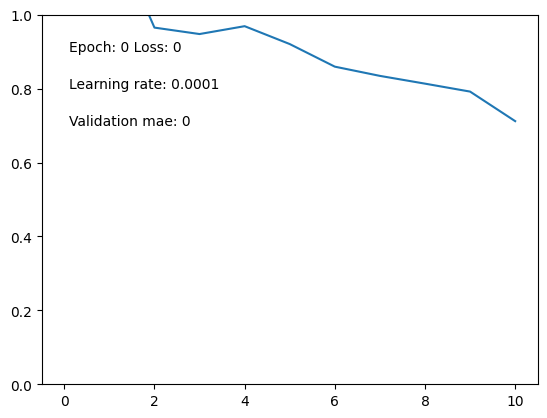

In [ ]:
train(
    diffusion_imputer, 
    data_loader_model, 
    data_loader_validation,
    epochs = 30, 
    lr = 0.0001, 
    loss_func = diffusion_imputer.loss_func,
    validation_frequency=4,
    validation_prp=14)

In [ ]:
#save the entire model for further training
#torch.save(diffusion_imputer, "/work/postresearch/Shared/Projects/Farbod/diffusion_imputer_forecast_last_4.pt")
#torch.save(diffusion_imputer, "/work/postresearch/Shared/Projects/Farbod/diffusion_imputer_27.pt")
